# Projet MACS205 - ODE
## Rayane Dakhlaoui & Adam Chgour & Alexendre Mallez & Arthur Hottier

In [26]:
# Bibiliothèques
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.stats import linregress

---
## Code du fichier carbone.py

In [27]:
# Initial conditions
Atmosphere_Initial = 750
CarbonateRock_Initial = 100000000
DeepOcean_Initial = 38000
FossilFuel_Initial = 7500
Plant_Initial = 560
Soil_Initial = 1500
SurfaceOcean_Initial = 890
VegLandArea_percent_Initial = 100

x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)


# Fossil fuels
FossFuelData = np.array([[1850.0, 0.00], [1875.0, 0.30], [1900.0, 0.60], [1925.0, 1.35], [1950.0, 2.85], [1975.0, 4.95], [2000.0, 7.20], [2025.0, 10.05], [2050.0, 14.85], [2075.0, 20.70], [2100.0, 30.00]])

def FossilFuelsCombustion(t):
     i = 0
     if t >= FossFuelData[-1,0]:
         return FossFuelData[-1,1]
     while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
         i = i + 1
     if i == 0:
         return FossFuelData[0,1]
     else:
         return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

# def FossilFuelsCombustion(t):
#     return 30/(1+np.exp(-(t-2050)/40))

def derivative(x, t):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0

    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative

---

## Implémentation et Comparaison de la méthode d'Euler et de la méthode de Rung-Kutta d'ordre 4

### Méthode d'Euler pour la résolution des équations différentielles du type $\mathbb{y' = f(t,y)}$ sur $\mathbb{R}$

In [28]:
def euler(f, y0, step, t0, T):  
      
    time_grid = np.arange(t0, t0 + T + step, step)
    y = [y0]
    dt = step
    
    for j in range(0,len(time_grid)-1):
        y_n = y[j] + dt * f(time_grid[j],y[j])
        y.append(y_n)
        
    return time_grid , np.array(y)

### Méthode d'Euler généralisée pour la résolution des équations différentielles du type $\mathbb{y' = f(t,y)}$ sur $\mathbb{R}^n$ 



In [29]:
def euler_generalise(f, y0 , step, t0, T):
    
    time_grid = np.arange(t0, t0 + T + step, step)
    y = np.zeros((len(time_grid), len(y0)))
    y[0,:] = y0  
    dt = step
    
    for j in range(len(time_grid) - 1):
        y[j+1,:] = y[j, :] + dt * f(y[j, :], time_grid[j]) 
         
    return time_grid , y


### Méthode de Runge-Kutta d'ordre 4 sur $\mathbb{R}$ 

In [30]:
def runge_kutta_4(f, y0, step, t0, T):

    time_grid = np.arange(t0, t0 + T + step, step)
    y = [y0]
    dt = step

    for j in range(len(time_grid) - 1):

        p_n_1 = f(time_grid[j],y[j])
        t_n_2 = time_grid[j] + 1/2 * dt
        y_n_2 = y[j] + 1/2 * dt * p_n_1
        p_n_2 = f(t_n_2, y_n_2)

        t_n_3 = t_n_2
        y_n_3 = y[j] + 1/2 * dt * p_n_2
        p_n_3 = f(t_n_3,y_n_3)

        t_n_4 = time_grid[j] + dt
        y_n_4 = y[j] + dt * p_n_3
        p_n_4 = f(t_n_4, y_n_4)
        
        y.append(y[j] + dt * (1/6 * p_n_1 + 2/6 * p_n_2 + 2/6 * p_n_3 + 1/6 * p_n_4))

    return  time_grid, y

### Méthode de Runge-Kutta d'ordre 4 sur $\mathbb{R}^n$ 

In [31]:
def runge_kutta_4_generalise(f, y0, step, t0, T):
    
    time_grid = np.arange(t0, t0 + T + step, step)
    y = np.zeros((len(time_grid), len(y0)))
    y[0,:] = y0
    dt = step

    for j in range(len(time_grid) - 1):

        p_n_1 = f(y[j,:],time_grid[j])
        t_n_2 = time_grid[j] + 1/2 * dt
        y_n_2 = y[j,:] + 1/2 * dt * p_n_1
        p_n_2 = f(y_n_2,t_n_2)

        t_n_3 = t_n_2
        y_n_3 = y[j,:] + 1/2 * dt * p_n_2
        p_n_3 = f(y_n_3,t_n_3)

        t_n_4 = time_grid[j] + dt
        y_n_4 = y[j,:] + dt * p_n_3
        p_n_4 = f(y_n_4,t_n_4)
        
        y[j+1,:] = y[j,:] + dt * (1/6 * p_n_1 + 2/6 * p_n_2 + 2/6 * p_n_3 + 1/6 * p_n_4)

    return  time_grid, y

### Comparaison des 2 méthodes 

On prend l'équation différentielle linéaire avec coefficients constant suivante: $\mathbb{y' = f(t,y) = \frac{1}{1+e^{t}} - y}$ sur $\mathbb{R}$ dont la solution exacte est $y(t) = \ln(1 + e^t) \cdot e^{-t} + e^{-t}$

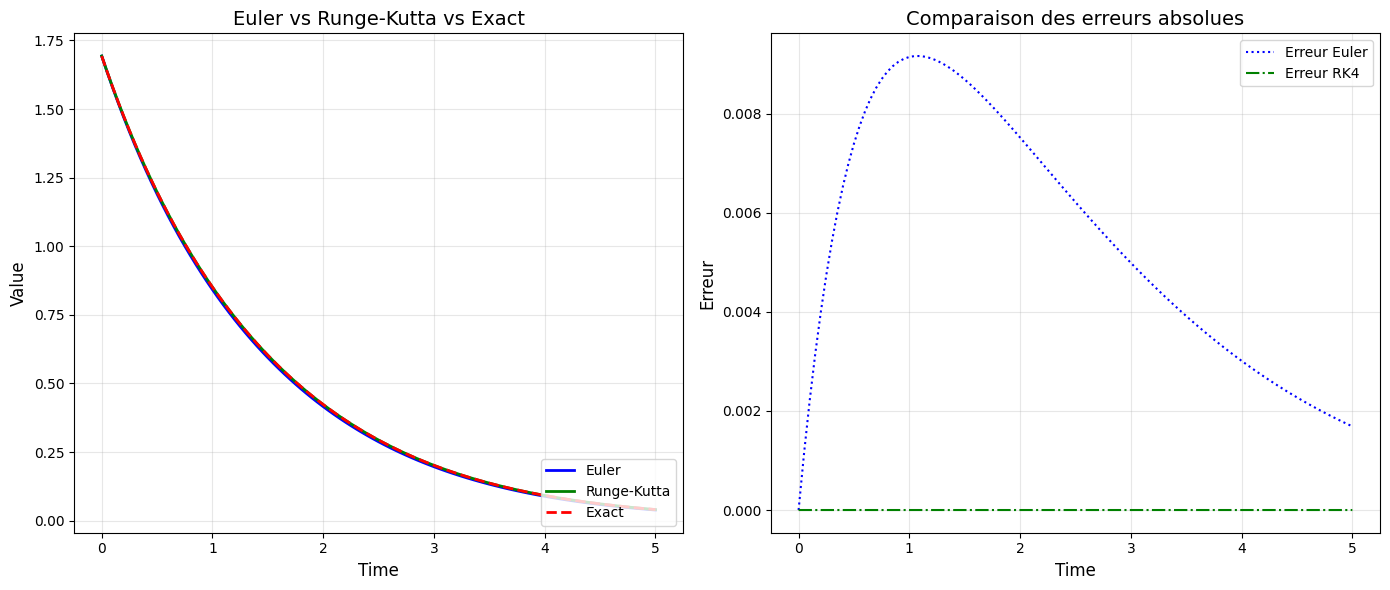

In [32]:
def f(t,y):  
    return 1/(1 + np.exp(t)) - y

def exact_function(t):  
    return np.log(1 + np.exp(t))*np.exp(-t) + np.exp(-t)

y0 = exact_function(0)

t_euler, y_euler = euler(f=f, y0=y0, step=0.05, t0=0, T=5)
t_rk4, y_rk = runge_kutta_4(f=f, y0=y0, step=0.05, t0=0, T=5)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t_euler, y_euler, 'b-', linewidth=2, label='Euler')
plt.plot(t_rk4, y_rk, 'g-', linewidth=2, label='Runge-Kutta')
plt.plot(t_euler, exact_function(t_euler), 'r--', linewidth=2, label='Exact')
plt.title('Euler vs Runge-Kutta vs Exact', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(t_euler, np.abs(y_euler - exact_function(t_euler)), 'b:', label='Erreur Euler')
plt.plot(t_rk4, np.abs(y_rk - exact_function(t_rk4)), 'g-.', label='Erreur RK4')
plt.title('Comparaison des erreurs absolues', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Erreur', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

**<u>Observations:</u>** 
- En observant la figure de gauche, on voit les 2 méthodes sont assez précises et suivent assez bien la courbe exacte (nous avons pris comme valeur initiale la valeur de notre solution exacte à l'instant t = 0)

- Lorsque l'on observe la figure de droite, on observe que la méthode de Runge-Kutta est bien plus précise que la méthode d'Euler, ce qui semble cohérent car la méthode de Runge-Kutta est d'ordre 4 alors que la méthode d'Euler est seulement d'ordre 1.

---

In [33]:
def plot_results(t, x, subplots_info, title='Carbon Cycle Model'):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(15, 6)

    def create_subplot(ax, ylabel, color, position):
        ax.set_ylabel(ylabel, color=color)
        ax.plot(t, x[:, position], color=color)
        ax.tick_params(axis='y', labelcolor=color)
        ax.spines['right'].set_position(('outward', position * 55))

    for ylabel, color, position in subplots_info:
        if position == 0:
            create_subplot(ax1, ylabel, color, position)
        else:
            ax = ax1.twinx()
            create_subplot(ax, ylabel, color, position)

    ax1.set_xlabel('Year')
    ax1.set_title(title)
    ax1.grid()
    fig.tight_layout()
    plt.show()

In [34]:
# Paramètres 
f = derivative
y0 = x0
step = 0.01
t0 = 1850
T = 750

subplots_info = [
        ('Atmosphere', 'tab:red', 0),
        ('Carbonate Rock', 'tab:blue', 1),
        ('Deep Ocean', 'tab:green', 2),
        ('Fossil Fuel Carbon', 'tab:orange', 3),
        ('Plants', 'tab:purple', 4),
        ('Soil', 'tab:brown', 5),
        ('Surface Ocean', 'tab:cyan', 6),
        #('Veg Land Area %', 'tab:olive', 7)
    ]

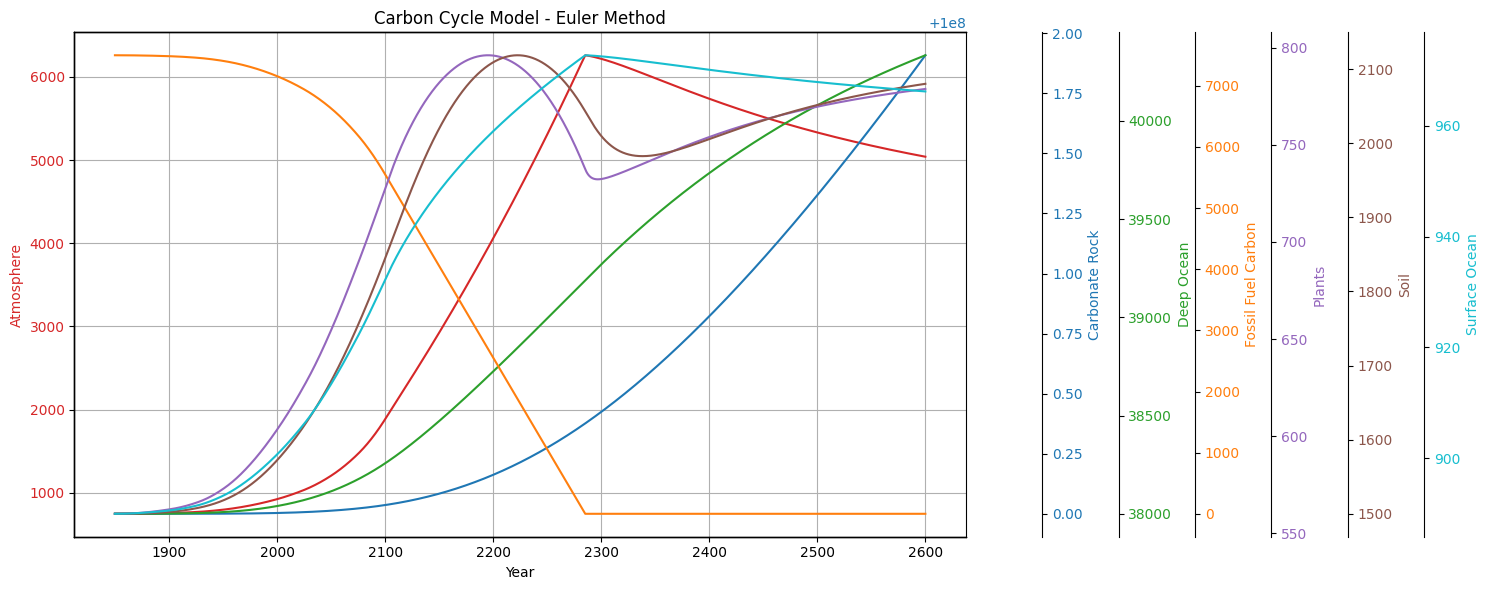

In [35]:
t_e, x_e = euler_generalise(f=f, y0=y0, step=step, t0=t0, T=T)
plot_results(t_e, x_e, subplots_info, title='Carbon Cycle Model - Euler Method')

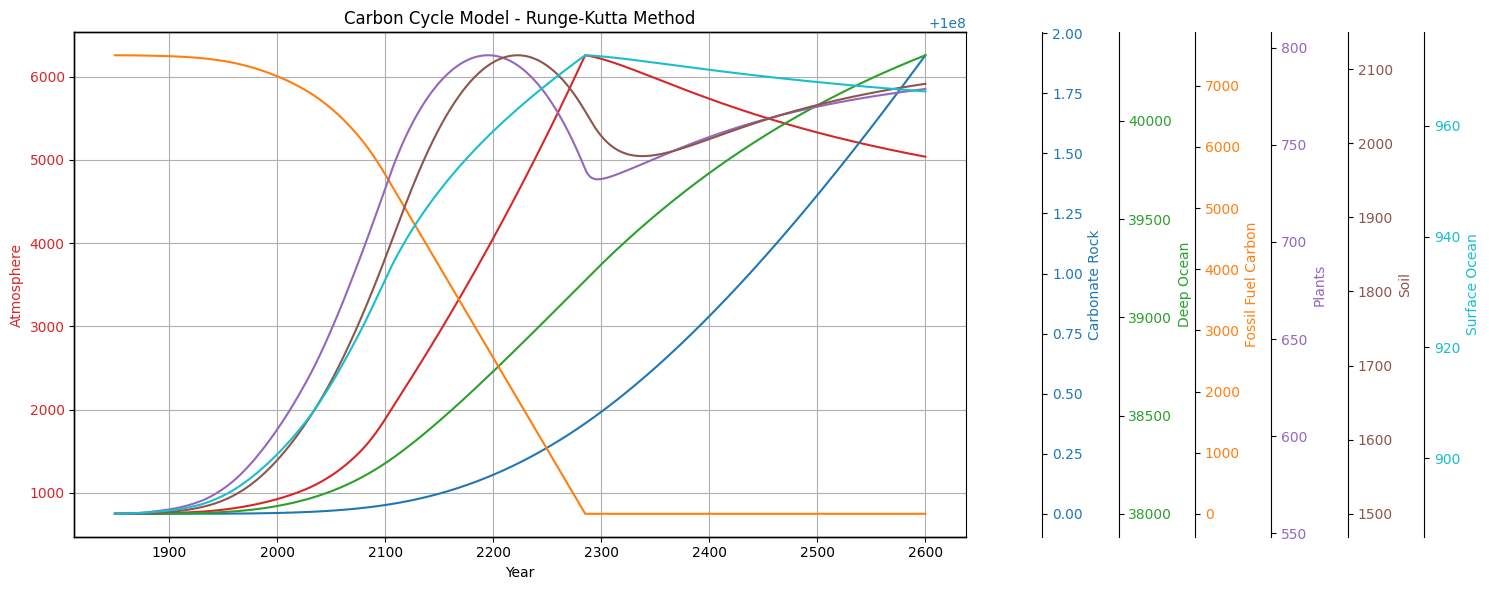

In [36]:
t_rk, x_rk = runge_kutta_4_generalise(f=f, y0=y0, step=step, t0=t0, T=T)
plot_results(t_rk, x_rk, subplots_info, title='Carbon Cycle Model - Runge-Kutta Method')

---

In [37]:
# make a reference plot to evaluate the accuracy of the implemented methods
def rk4(derivative, x0, t):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        k1 = derivative(x[i-1], t[i-1])
        k2 = derivative(x[i-1] + dt/2 * k1, t[i-1] + dt/2)
        k3 = derivative(x[i-1] + dt/2 * k2, t[i-1] + dt/2)
        k4 = derivative(x[i-1] + dt * k3, t[i-1] + dt)
        x[i] = x[i-1] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
    return x

t = np.linspace(1800, 2600, 500000)
x_ref = rk4(derivative, x0, t)
x_ref = interp1d(t, x_ref, axis=0)

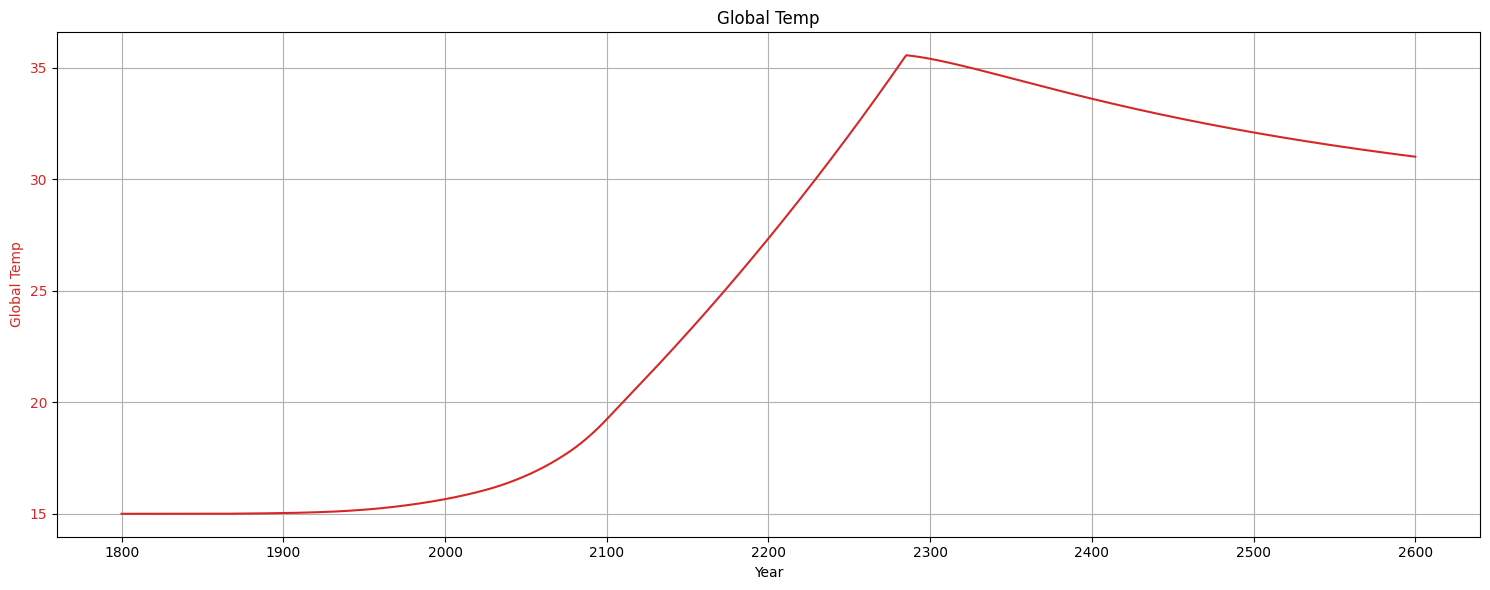

In [38]:
# plot GlobalTemp comme ref
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 6)
ax1.set_ylabel('Global Temp', color='tab:red')
ax1.plot(t, GlobalTemp(AtmCO2(x_ref(t)[:, 0])), color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.spines['right'].set_position(('outward', 0 * 55))
ax1.set_xlabel('Year')
ax1.set_title('Global Temp')
ax1.grid()
fig.tight_layout()
plt.show()

L'interpolation marche bien

In [39]:
def consistency_error(derivative, reference_solution, t):
    n = len(t)
    error = np.zeros((n-1, len(reference_solution[0])))
    for i in range(n-1):
        dt = t[i+1] - t[i]
        error[i] = (reference_solution[i+1] - reference_solution[i] - dt * derivative(reference_solution[i], t[i]))
    return np.linalg.norm(error, axis=1)

n_step = np.logspace(1, 4, 10, dtype=int)
error_data = []
max_error_data = []
sum_error_data = []
h_values = []
for n in n_step:
    t = np.linspace(1850, 2600, n)
    h_euler = (t[-1] - t[0]) / (len(t) - 1)
    h_values.append(h_euler)
    error_euler = consistency_error(derivative, x_ref(t), t)   
    
    error_data.append(error_euler)
    max_error_data.append(np.max(error_euler))
    sum_error_data.append(np.sum(error_euler))

In [40]:
def consistency_error_rk4(derivative, reference_solution, t, h):
    n = len(t)
    error = np.zeros((n-1, len(reference_solution[0])))
    for i in range(n-1):
        dt = t[i+1] - t[i]
        k1 = derivative(reference_solution[i], t[i])
        k2 = derivative(reference_solution[i] + dt/2 * k1, t[i] + dt/2)
        k3 = derivative(reference_solution[i] + dt/2 * k2, t[i] + dt/2)
        k4 = derivative(reference_solution[i] + dt * k3, t[i] + dt)
        predicted_value = reference_solution[i] + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
        error[i] = predicted_value - reference_solution[i+1]
    return np.linalg.norm(error, axis=1)

n_step = np.logspace(1, 3, 10, dtype=int)
error_data_rk4 = []
max_error_data_rk4 = []
sum_error_data_rk4 = []
h_values_rk4 = []
for n in n_step:
    t = np.linspace(1850, 2600, n)
    h_rk4 = (t[-1] - t[0]) / (len(t) - 1)
    h_values_rk4.append(h_rk4)
    error_rk4 = consistency_error_rk4(derivative, x_ref(t), t, h_rk4)   
    error_data_rk4.append(error_rk4)
    max_error_data_rk4.append(np.max(error_rk4))
    sum_error_data_rk4.append(np.sum(error_rk4))



### Erreur de consistance maximale :
D'après le cours, $ \max_{h_{n}} \| e(t_n, h_n, y_n) \| \longrightarrow \| e(t_n, h_n, y_n) \| \leq C h_n^{p+1} $

où :

- $h_n$ : le pas
- $e(t_n, h_n, y_n)$ : l’erreur locale de consistance à l’instant $t_n$.  
- $p$ : l’ordre de la méthode (Euler (p = 1), Runge-Kutta 4 (p = 4)).  
- $C$ : constante

Cela signifie que l’erreur locale décroit en $h_n^{p+1}$ si le schéma est d’ordre $p$.


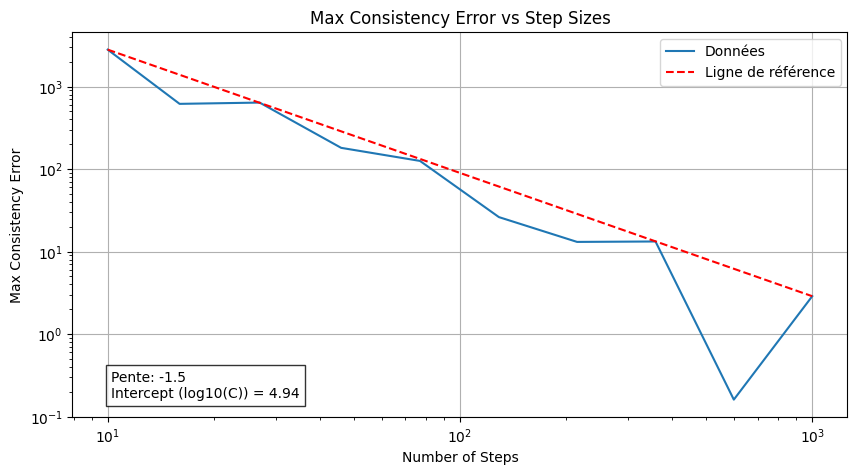

Pente (log-log): -1.5
Intercept (log10(C)): 4.942606


In [41]:
# plt.figure(figsize=(10, 5)) 
# plt.plot(n_step, max_error_data)
# plt.xlabel('Number of Steps')
# plt.ylabel('Max Consistency Error')
# plt.title('Max Consistency Error vs Step Sizes')
# plt.xscale('log')
# plt.yscale('log')
# plt.grid(True)
# plt.show()


plt.figure(figsize=(10, 5))
plt.plot(n_step, max_error_data, label='Données')

x0, y0 = n_step[0], max_error_data[0]
x1, y1 = n_step[-1], max_error_data[-1]
plt.plot([x0, x1], [y0, y1], 'r--', label='Ligne de référence')

log_x0, log_y0 = np.log10(x0), np.log10(y0)
log_x1, log_y1 = np.log10(x1), np.log10(y1)
slope = (log_y1 - log_y0) / (log_x1 - log_x0)
intercept = log_y0 - slope * log_x0

plt.text(0.05, 0.05, f'Pente: {slope:.1f}\nIntercept (log10(C)) = {intercept:.2f}', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('Number of Steps')
plt.ylabel('Max Consistency Error')
plt.title('Max Consistency Error vs Step Sizes')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

print(f"Pente (log-log): {slope:.1f}")
print(f"Intercept (log10(C)): {intercept:1f}")


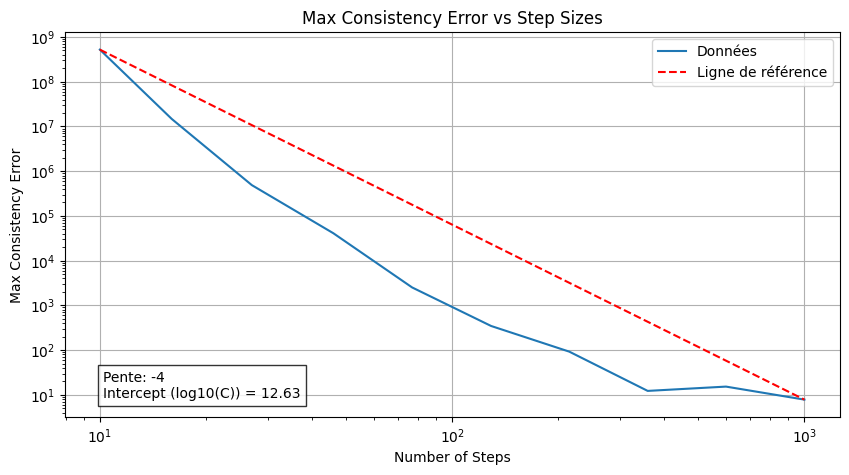

Pente (log-log): -4
Intercept (log10(C)): 12.6


In [42]:
# plt.figure(figsize=(10, 5)) 
# plt.plot(n_step, max_error_data_rk4)
# plt.xlabel('Number of Steps')
# plt.ylabel('Max Consistency Error')
# plt.title('Max Consistency Error vs Step Sizes for Runge-Kutta 4')
# plt.xscale('log')
# plt.yscale('log')
# plt.grid(True)
# plt.show()

plt.figure(figsize=(10, 5))
plt.plot(n_step, max_error_data_rk4, label='Données')

x0, y0 = n_step[0], max_error_data_rk4[0]
x1, y1 = n_step[-1], max_error_data_rk4[-1]
plt.plot([x0, x1], [y0, y1], 'r--', label='Ligne de référence')

log_x0, log_y0 = np.log10(x0), np.log10(y0)
log_x1, log_y1 = np.log10(x1), np.log10(y1)
slope = (log_y1 - log_y0) / (log_x1 - log_x0)
intercept = log_y0 - slope * log_x0

plt.text(0.05, 0.05, f'Pente: {slope:.0f}\nIntercept (log10(C)) = {intercept:.2f}', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('Number of Steps')
plt.ylabel('Max Consistency Error')
plt.title('Max Consistency Error vs Step Sizes')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

print(f"Pente (log-log): {slope:.0f}")
print(f"Intercept (log10(C)): {intercept:.1f}")


### Consistance globale 

On montre que les deux méthodes sont consistantes, i.e. l’erreur de consistance globale (la somme des erreurs locales) tend vers zéro lorsque $h \to 0$ .

$$
h \to 0 \quad \Rightarrow \quad \sum_n \| e(t_n, h, y_n) \| \longrightarrow 0
$$

Autrement dit, la somme des erreurs locales tend vers zéro quand on affine $h$.


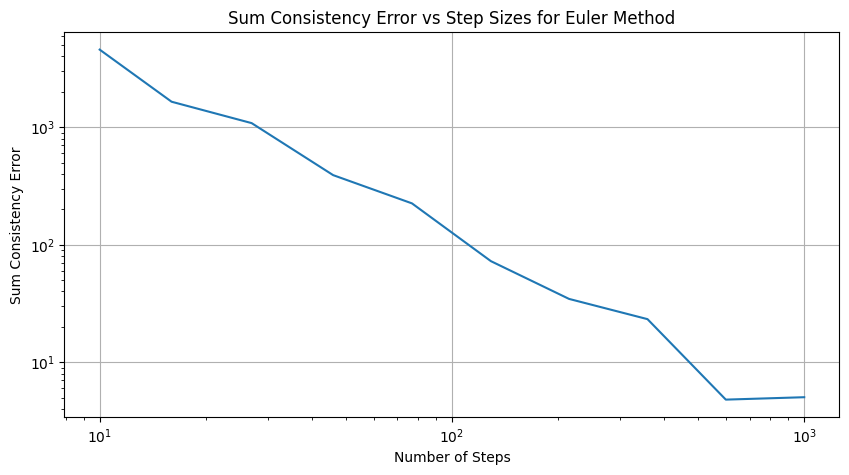

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(n_step, sum_error_data)
plt.xlabel('Number of Steps')
plt.ylabel('Sum Consistency Error')
plt.title('Sum Consistency Error vs Step Sizes for Euler Method')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

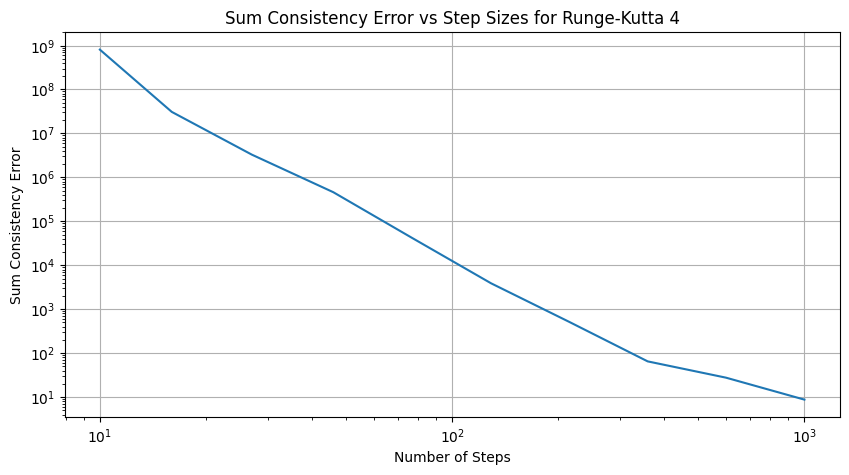

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(n_step, sum_error_data_rk4)
plt.xlabel('Number of Steps')
plt.ylabel('Sum Consistency Error')
plt.title('Sum Consistency Error vs Step Sizes for Runge-Kutta 4')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()


**<u>Conclusion:</u>** Les deux méthodes sont consistantes car l'erreur de consistance globale $\sum_n || e(t_n, h, y_n) ||$ tend bien vers zéro lorsque $h \to 0$.

---

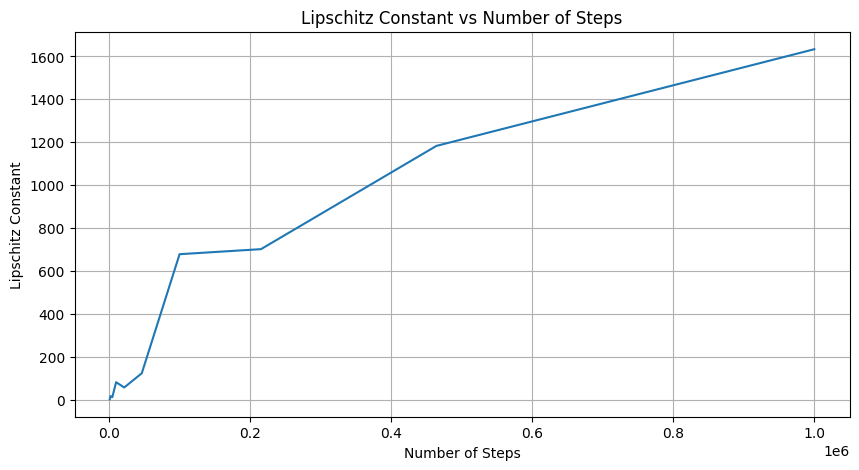

In [45]:
def lipschitz_constant(derivative, x, t):
    n = len(t)
    L = 0
    for i in range(n-1):
        L = max(L, np.linalg.norm(derivative(x[i+1], t[i+1]) - derivative(x[i], t[i])) / np.linalg.norm(x[i+1] - x[i]))
    return L

n_step = np.logspace(3, 6, 10, dtype=int)
lipschitz_constant_data = []
for n in n_step:
    t = np.linspace(1850, 2600, n)
    lipschitz_constant_data.append(lipschitz_constant(derivative, x_ref(t), t))

plt.figure(figsize=(10, 5))
plt.plot(n_step, lipschitz_constant_data)
plt.xlabel('Number of Steps')
plt.ylabel('Lipschitz Constant')
plt.title('Lipschitz Constant vs Number of Steps')
plt.grid(True)
plt.show()

**<u>Conclusion:</u>** La fonction $f$ n'est pas Lipschitz continue, car sa constante de Lipschitz L n'est pas uniformément bornée : elle dépend de $h$ et diverge quand $h \to 0$.

---

## Stabilité :

$$
S = \frac{\max_n \left\| \tilde{y}_n - y_n \right\|}{\left\| \tilde{y}_0 - y_0 \right\| + \sum_n \left\| \epsilon_n \right\|}
$$

On crée l'erreur tel qu'elle suit une gaussienne centré en 0 et de variance 1 : 

In [46]:
# On utilise le même x_ref que pour la consistence
x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])
t = np.linspace(1800, 2600, 10000)
x_ref = rk4(derivative, x0, t)
# Normalisation des données pour une meilleure visualisation
x_normalized = x_ref / x_ref.max(axis=0)
x_ref = interp1d(t, x_normalized, axis=0)


In [47]:
#Pour ajouter le bruit à chaque itération
def rk4_noise(derivative, x0, t, epsilons):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        k1 = derivative(x[i-1], t[i-1])
        k2 = derivative(x[i-1] + dt/2 * k1, t[i-1] + dt/2)
        k3 = derivative(x[i-1] + dt/2 * k2, t[i-1] + dt/2)
        k4 = derivative(x[i-1] + dt * k3, t[i-1] + dt)
        x[i] = x[i-1] + dt/6 * (k1 + 2*k2 + 2*k3 + k4) + epsilons[i]
    return x

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


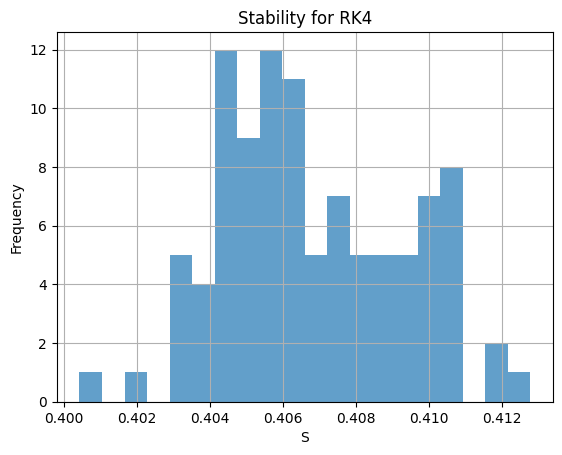

Estimated S_rk4 ≈ 0.41


In [48]:
from tqdm import tqdm
num_trials = 100
sigma = 0.01  # ≈ 1% de l'amplitude par variable

stability_scores = []
t = np.linspace(1850, 2600, 10000)
y_ref = x_ref(t)
dim = y_ref.shape[1]
# scale = np.mean(np.linalg.norm(y_ref)) / 100  # bruit ≈ 1% de la norme moyenne
# print(f"scale = {scale:.2f}")
for trial in tqdm(range(num_trials)):
    #epsilons = np.random.normal(0, scale, size=y_ref.shape)
    epsilons = np.random.normal(0, sigma, size=y_ref.shape)
    #epsilons[:, -1] = 0 #le dernier paramètre est constant
    y0_perturbed = y_ref[0] + epsilons[0]
    y_perturbed = rk4_noise(derivative, y0_perturbed, t, epsilons)
    numerator = np.max(np.linalg.norm(y_perturbed - y_ref, axis=1))
    denominator = np.linalg.norm(y_ref[0] - y0_perturbed) + np.sum(np.linalg.norm(epsilons, axis=1))
    
    # Ensure denominator is valid and non-zero
    if denominator > 0:
        S = numerator / denominator
        stability_scores.append(S)
    else:
        stability_scores.append(np.nan)  # Append NaN if denominator is invalid

plt.hist(stability_scores, bins=20, alpha=0.7)
plt.title("Stability for RK4")
plt.xlabel("S")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Estimated S_rk4 ≈ {np.max(stability_scores):.2f}")


In [49]:
def euler_noise(derivative, x0, t, epsilons):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        x[i] = x[i-1] + dt * derivative(x[i-1], t[i-1]) + epsilons[i]
    return x

100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


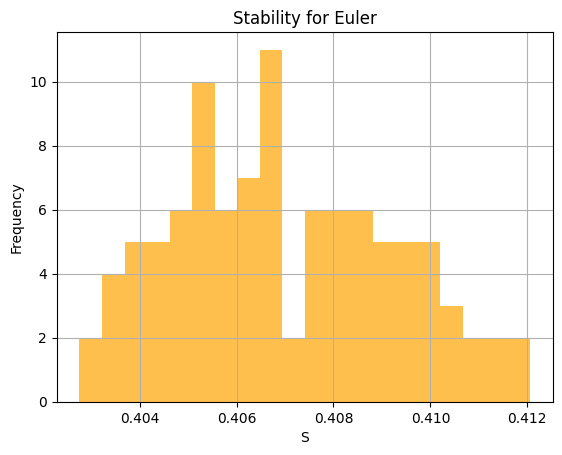

Estimated S_euler ≈ 0.41


In [50]:
num_trials = 100
sigma = 0.01

stability_scores_euler = []
t = np.linspace(1850, 2600, 10000)
y_ref = x_ref(t)  # x_ref reste généré avec RK4, c’est notre référence
dim = y_ref.shape[1]

for trial in tqdm(range(num_trials)):
    epsilons = np.random.normal(0, sigma, size=y_ref.shape)
    #epsilons[:, -1] = 0
    y0_perturbed = y_ref[0] + epsilons[0]
    y_perturbed = euler_noise(derivative, y0_perturbed, t, epsilons)

    numerator = np.max(np.linalg.norm(y_perturbed - y_ref, axis=1))
    denominator = np.linalg.norm(y_ref[0] - y0_perturbed) + np.sum(np.linalg.norm(epsilons, axis=1))
    S = numerator / denominator
    stability_scores_euler.append(S)

plt.hist(stability_scores_euler, bins=20, alpha=0.7, color='orange')
plt.title("Stability for Euler")
plt.xlabel("S")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Estimated S_euler ≈ {np.max(stability_scores_euler):.2f}")

En fonction de N :

[  1000   1668   2782   4641   7742  12915  21544  35938  59948 100000]


100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


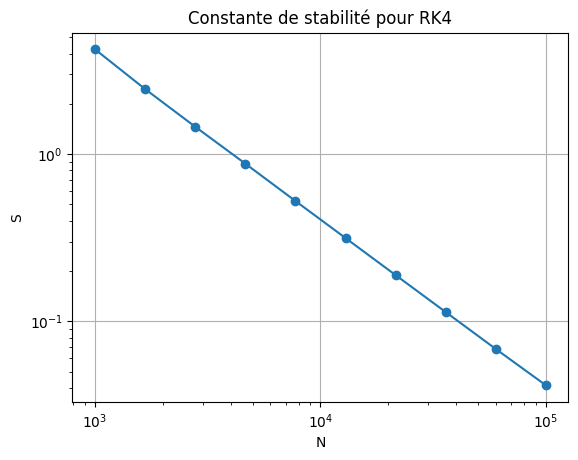

Estimated S_euler ≈ 1.03


In [51]:
num_trials = 10
sigma = 0.01
stability_score_total_euler=[]

n_step = np.logspace(3, 5, 10, dtype=int)
print(n_step)
for n in tqdm(n_step):
    t = np.linspace(1850, 2600, n)
    y_ref = x_ref(t)
    stability_score_euler = []
    for trial in range(num_trials):
        epsilons = np.random.normal(0, sigma, size=y_ref.shape)
        y0_perturbed = y_ref[0] + epsilons[0]
        y_perturbed = euler_noise(derivative, y0_perturbed, t, epsilons)

        numerator = np.max(np.linalg.norm(y_perturbed - y_ref, axis=1))
        denominator = np.linalg.norm(y_ref[0] - y0_perturbed) + np.sum(np.linalg.norm(epsilons, axis=1))
        S = numerator / denominator
        stability_score_euler.append(S)
    stability_score_euler = [x for x in stability_score_euler if not np.isnan(x)]
    stability_score_total_euler.append(np.mean(stability_score_euler))


plt.title("Constante de stabilité pour RK4")
plt.xlabel("N")
plt.ylabel("S")
plt.plot(n_step, stability_score_total_euler, 'o-', label='Stability Score')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

print(f"Estimated S_euler ≈ {np.mean(stability_score_total_euler):.2f}")

[  3162   7498  17782  42169 100000]


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


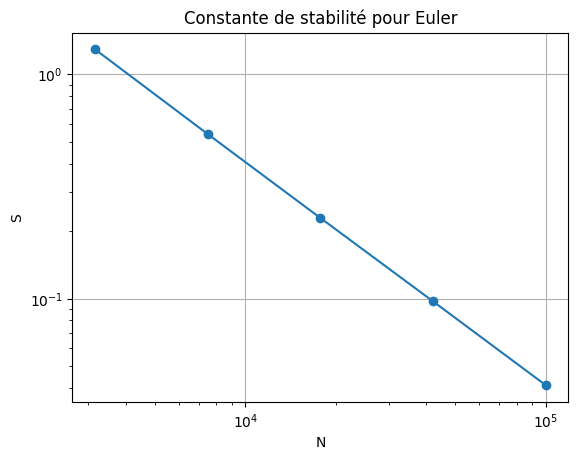

Estimated S_euler ≈ 1.29


In [52]:
num_trials = 2
sigma = 0.01
stability_score_total_rk4=[]

n_step = np.logspace(3.5, 5, 5, dtype=int)
print(n_step)
for n in tqdm(n_step):
    t = np.linspace(1850, 2600, n)
    y_ref = x_ref(t)
    stability_score_rk4 = []
    for trial in range(num_trials):
        epsilons = np.random.normal(0, sigma, size=y_ref.shape)
        y0_perturbed = y_ref[0] + epsilons[0]
        y_perturbed = euler_noise(derivative, y0_perturbed, t, epsilons)

        numerator = np.max(np.linalg.norm(y_perturbed - y_ref, axis=1))
        denominator = np.linalg.norm(y_ref[0] - y0_perturbed) + np.sum(np.linalg.norm(epsilons, axis=1))
        S = numerator / denominator
        stability_score_rk4.append(S)
    stability_score_rk4 = [x for x in stability_score_rk4 if not np.isnan(x)]
    stability_score_total_rk4.append(np.mean(stability_score_rk4))


plt.title("Constante de stabilité pour Euler")
plt.xlabel("N")
plt.ylabel("S")
plt.plot(n_step, stability_score_total_rk4, 'o-', label='Stability Score')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

print(f"Estimated S_euler ≈ {np.max(stability_score_total_rk4):.2f}")

---
## Vitesse de convergence

In [53]:
from tqdm import tqdm
h_values = np.linspace(0.01, 0.2, 100)
errors = []

for h in tqdm(h_values):
    t0, T = 1800, 700
    y0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Taille 8
    t, y= euler_generalise(f=f, y0=y0, step=h, t0=t0, T=T)
    exact = x_ref(t)  # Use the adjusted t array
    error = np.linalg.norm(y[:, 1] - exact[:,1], ord=np.inf)  # Erreur maximale
    errors.append(error)

# Calcul de la vitesse de convergence
rates = []
for i in range(1, len(errors)):
    rate = np.log(errors[i] / errors[i - 1]) / np.log(h_values[i] / h_values[i - 1])
    rates.append(rate)

# Affichage des résultats
print("Tailles de pas (h):", h_values)
print("Erreurs globales :", errors)
#print("Vitesses de convergence :", rates)

100%|██████████| 100/100 [00:11<00:00,  8.89it/s]

Tailles de pas (h): [0.01       0.01191919 0.01383838 0.01575758 0.01767677 0.01959596
 0.02151515 0.02343434 0.02535354 0.02727273 0.02919192 0.03111111
 0.0330303  0.03494949 0.03686869 0.03878788 0.04070707 0.04262626
 0.04454545 0.04646465 0.04838384 0.05030303 0.05222222 0.05414141
 0.05606061 0.0579798  0.05989899 0.06181818 0.06373737 0.06565657
 0.06757576 0.06949495 0.07141414 0.07333333 0.07525253 0.07717172
 0.07909091 0.0810101  0.08292929 0.08484848 0.08676768 0.08868687
 0.09060606 0.09252525 0.09444444 0.09636364 0.09828283 0.10020202
 0.10212121 0.1040404  0.1059596  0.10787879 0.10979798 0.11171717
 0.11363636 0.11555556 0.11747475 0.11939394 0.12131313 0.12323232
 0.12515152 0.12707071 0.1289899  0.13090909 0.13282828 0.13474747
 0.13666667 0.13858586 0.14050505 0.14242424 0.14434343 0.14626263
 0.14818182 0.15010101 0.1520202  0.15393939 0.15585859 0.15777778
 0.15969697 0.16161616 0.16353535 0.16545455 0.16737374 0.16929293
 0.17121212 0.17313131 0.17505051 0.176969

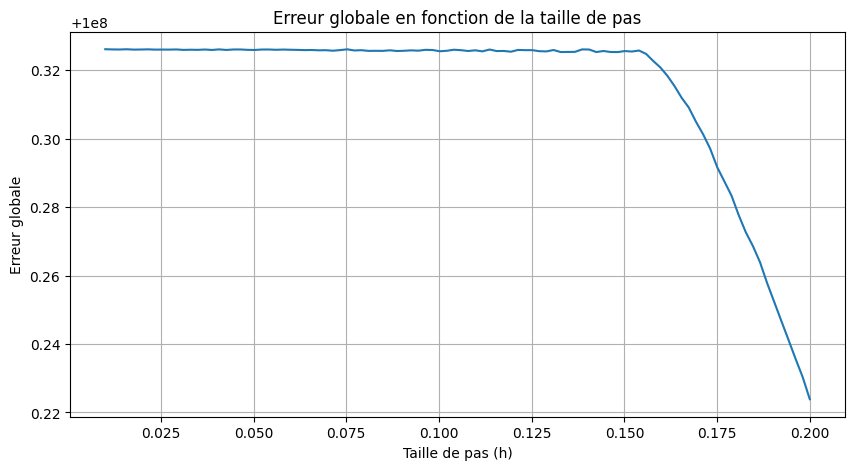

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(h_values, errors)
plt.xlabel('Taille de pas (h)')
plt.ylabel('Erreur globale')
plt.title('Erreur globale en fonction de la taille de pas')
plt.grid(True)
plt.show()

In [55]:
from tqdm import tqdm
h_values = np.linspace(0.1, 0.5, 100)
errors_e = [[]for _ in range(7)]
errors_r = [[]for _ in range(7)]

for h in tqdm(h_values):
    t0, T = 1800, 700
    y0 = np.array([750, 100000000, 38000, 7500, 560, 1500, 890, 100])  # Taille 8
    te, ye= euler_generalise(f=f, y0=y0, step=h, t0=t0, T=T)
    tr, yr= runge_kutta_4_generalise(f=f, y0=y0, step=h, t0=t0, T=T)
    exact_e = x_ref(te)  # Use the adjusted t array
    exact_r = x_ref(tr)  # Use the adjusted t array
    for i in range(7):
        error = np.linalg.norm(ye[:, i] - exact_e[:,i], ord=np.inf)  # Erreur maximale
        errors_e[i].append(error)
        error = np.linalg.norm(yr[:, i] - exact_r[:,i], ord=np.inf)
        errors_r[i].append(error)

# Affichage des résultats
print("Tailles de pas (h):", h_values)
print("Erreurs globales :", errors)
#print("Vitesses de convergence :", rates)

 62%|██████▏   | 62/100 [00:11<00:04,  8.62it/s]/var/folders/j6/q6rynzzn2hgdqbyc348_krnw0000gn/T/ipykernel_35237/2329565665.py:45: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
 63%|██████▎   | 63/100 [00:11<00:04,  8.78it/s]/var/folders/j6/q6rynzzn2hgdqbyc348_krnw0000gn/T/ipykernel_35237/2329565665.py:37: RuntimeWarning: overflow encountered in scalar multiply
  return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
/var/folders/j6/q6rynzzn2hgdqbyc348_krnw0000gn/T/ipykernel_35237/2329565665.py:45: RuntimeWarning: overflow encountered in scalar multiply
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
/var/folders/j6/q6rynzzn2hgdqbyc348_krnw0000gn/T/ipykernel_35237/2329565665.py:49: RuntimeWarning: invalid value encountered in scalar divide
  return 280*KCO2*(HCO3**2/CO3)
 65%|██████▌   | 65/100 [00:12<00:03,  9.14it/s]/var/folder

Tailles de pas (h): [0.1        0.1040404  0.10808081 0.11212121 0.11616162 0.12020202
 0.12424242 0.12828283 0.13232323 0.13636364 0.14040404 0.14444444
 0.14848485 0.15252525 0.15656566 0.16060606 0.16464646 0.16868687
 0.17272727 0.17676768 0.18080808 0.18484848 0.18888889 0.19292929
 0.1969697  0.2010101  0.20505051 0.20909091 0.21313131 0.21717172
 0.22121212 0.22525253 0.22929293 0.23333333 0.23737374 0.24141414
 0.24545455 0.24949495 0.25353535 0.25757576 0.26161616 0.26565657
 0.26969697 0.27373737 0.27777778 0.28181818 0.28585859 0.28989899
 0.29393939 0.2979798  0.3020202  0.30606061 0.31010101 0.31414141
 0.31818182 0.32222222 0.32626263 0.33030303 0.33434343 0.33838384
 0.34242424 0.34646465 0.35050505 0.35454545 0.35858586 0.36262626
 0.36666667 0.37070707 0.37474747 0.37878788 0.38282828 0.38686869
 0.39090909 0.39494949 0.3989899  0.4030303  0.40707071 0.41111111
 0.41515152 0.41919192 0.42323232 0.42727273 0.43131313 0.43535354
 0.43939394 0.44343434 0.44747475 0.451515

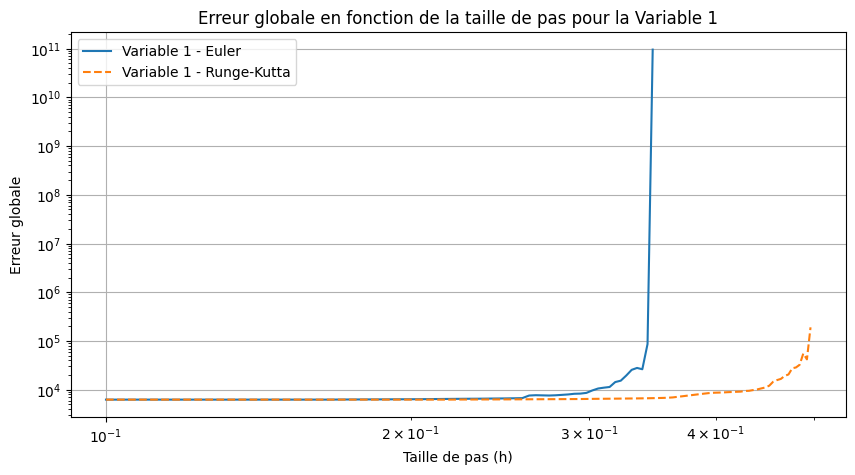

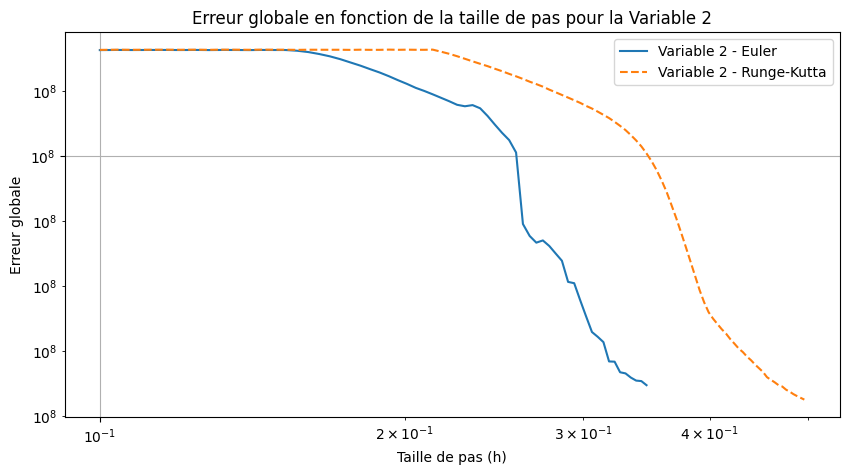

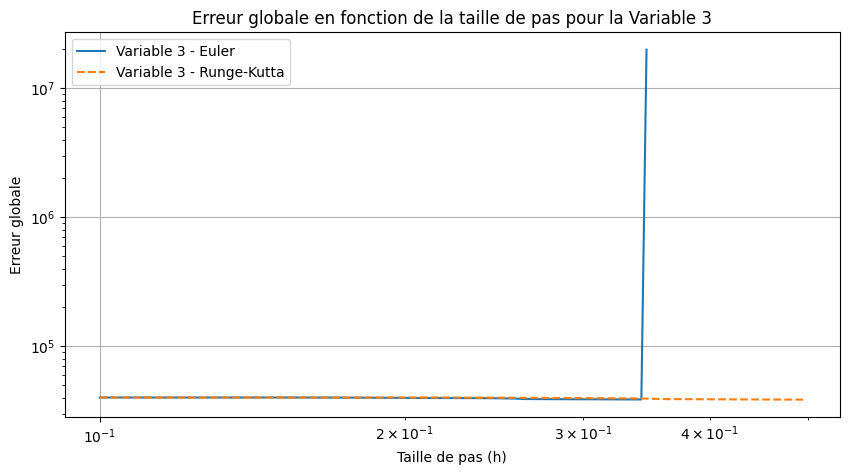

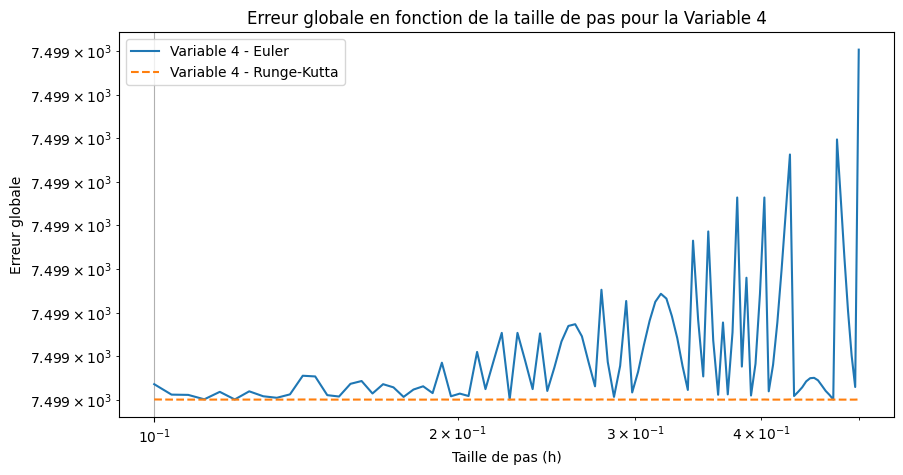

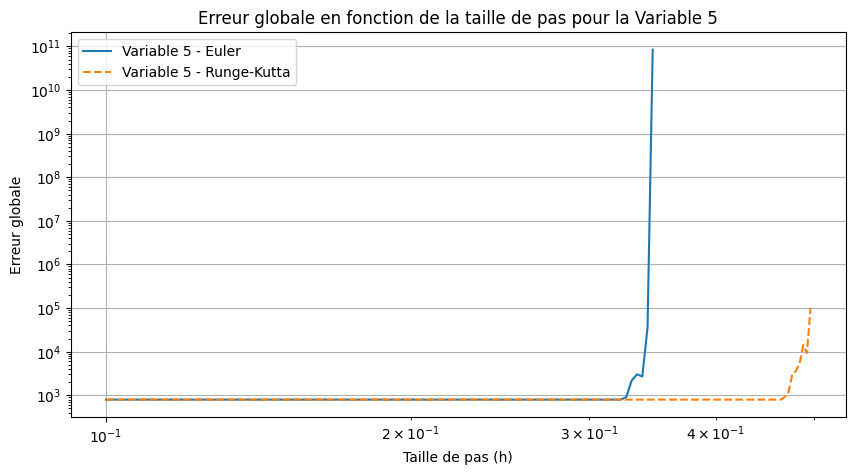

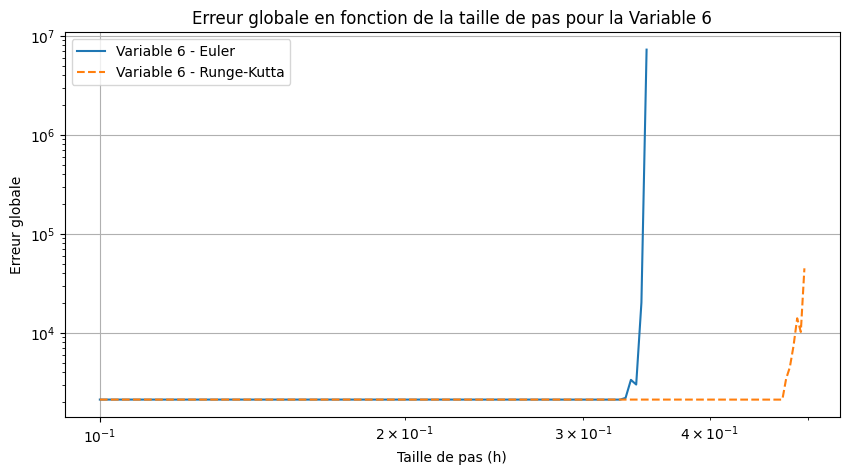

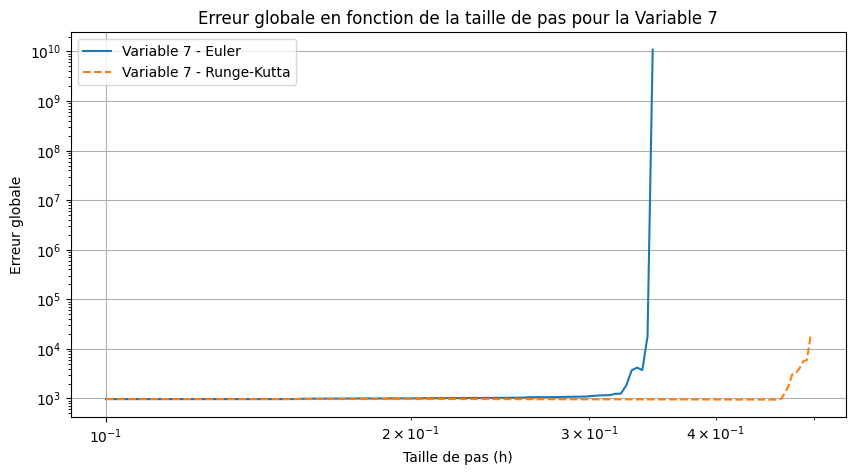

In [56]:
for i in range(len(errors_e)):
    plt.figure(figsize=(10, 5))
    plt.plot(h_values, errors_e[i], label=f'Variable {i+1} - Euler')
    plt.plot(h_values, errors_r[i], label=f'Variable {i+1} - Runge-Kutta', linestyle='--')
    plt.xlabel('Taille de pas (h)')
    plt.ylabel('Erreur globale')
    plt.title(f'Erreur globale en fonction de la taille de pas pour la Variable {i+1}')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

---